### Instructions

1. Get the numerical variables from our dataset.
2. Check using a distribution plot if the variables fit the theoretical normal or exponential distribution.
3. Check if any of the transformations (log-transform, etc.) we have seen up to this point changes the result.

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats

In [55]:
df = pd.read_csv('files_for_lab/we_fn_use_c_marketing_customer_value_analysis.csv')
df.shape

(9134, 24)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

In [61]:
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
df.head(2)

,customer,state,customer_lifetime_value,response,coverage,education,effective_to_date,employmentstatus,gender,income,...,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize


In [105]:
numericals = df.select_dtypes('number')
numericals.skew()

customer_lifetime_value          3.032280
income                           0.286887
monthly_premium_auto             2.123546
months_since_last_claim          0.278586
months_since_policy_inception    0.040165
number_of_open_complaints        2.783263
number_of_policies               1.253333
total_claim_amount               1.714966
dtype: float64

In [106]:
numericals.kurt()

customer_lifetime_value          13.823533
income                           -1.094326
monthly_premium_auto              6.193605
months_since_last_claim          -1.073668
months_since_policy_inception    -1.133046
number_of_open_complaints         7.749308
number_of_policies                0.363157
total_claim_amount                5.979401
dtype: float64

# Distributions

Text(0.5, 1.0, 'Exponential Distribution')

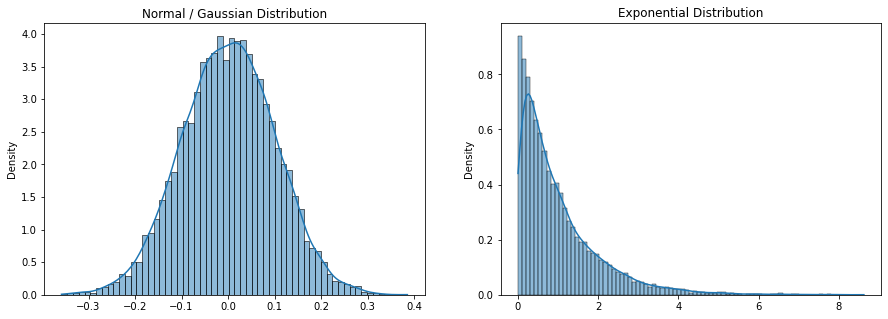

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))


# normal / Gaussian distribution shape
rng = np.random.default_rng()
mu, sigma = 0, 0.1 # mean and standard deviation
x_nor = rng.normal(mu, sigma, 10_000)
# exponential distribution
x_exp = rng.exponential(1, 10_000)

sns.histplot(data=x_nor, kde=True, stat='density', ax=ax[0])
sns.histplot(data=x_exp, kde=True, stat='density', ax=ax[1])
ax[0].set_title('Normal / Gaussian Distribution')
ax[1].set_title('Exponential Distribution')

In [97]:
SAFETY_MARGIN = 0.1

# helper func for distribution plots
def plot_distribution(df, col):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.histplot(data=df[col], kde=True, stat='density', ax=ax[0])
    ax[0].lines[0].set_color('blue')
    ax[0].set_title(f'Histogram + KDE curve for {col}')
  
    plt.subplot(1, 2, 2)
    stats.probplot(df[col], dist="norm", plot=plt)
    
# helper func for log tranformation
def log_transform(df, col):
    df[f'{col}_log'] = np.log(df[col]+SAFETY_MARGIN)
    plot_distribution(df, f'{col}_log')
    df.drop(f'{col}_log', axis=1, inplace=True)
    
# helper func for reciprocal tranformation    
def rec_transform(df, col):
    df[f'{col}_rec'] = 1/(df[col]+SAFETY_MARGIN)
    plot_distribution(df, f'{col}_rec')
    df.drop(f'{col}_rec', axis=1, inplace=True)
    

# helper func for square root tranformation    
def sq_transform(df, col):
    df[f'{col}_sq'] = df[col]**(1/2)
    plot_distribution(df, f'{col}_sq')
    df.drop(f'{col}_sq', axis=1, inplace=True)
    

# helper func for exponential tranformation    
def exp_transform(df, col):
    df[f'{col}_exp'] = df[col]**(1/5)
    plot_distribution(df, f'{col}_exp')
    df.drop(f'{col}_exp', axis=1, inplace=True)
    
    
# helper func for boxcox tranformation    
def boxcox_transform(df, col):
    df[f'{col}_boxcox'], _ = stats.boxcox(df[col]+SAFETY_MARGIN)
    plot_distribution(df, f'{col}_boxcox')
    df.drop(f'{col}_boxcox', axis=1, inplace=True)
    
    
def apply_all_transformations(df, col):
    log_transform(df, col)
    rec_transform(df, col)
    sq_transform(df, col)
    exp_transform(df, col)
    boxcox_transform(df, col)

### Income

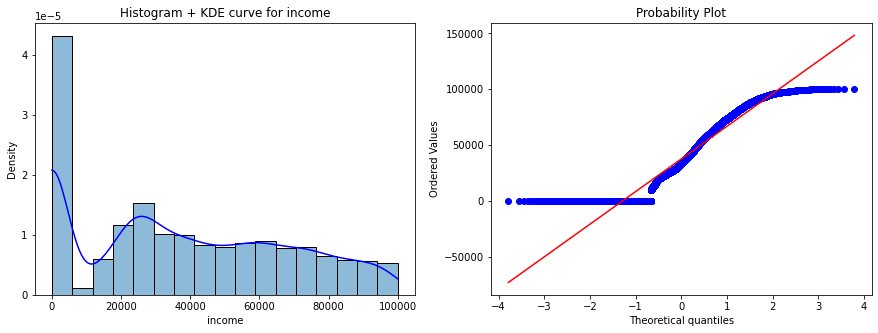

In [98]:
plot_distribution(df, 'income')

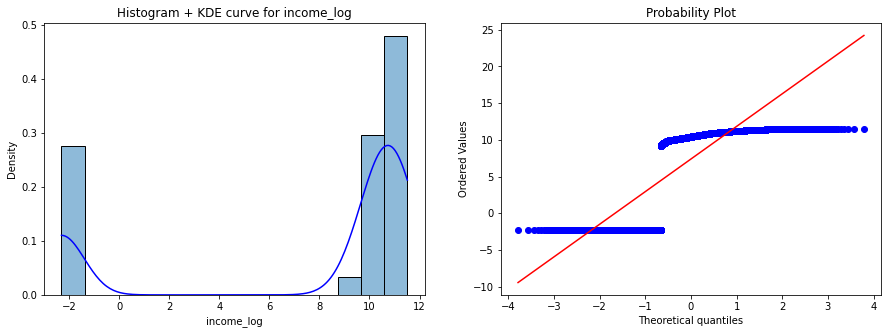

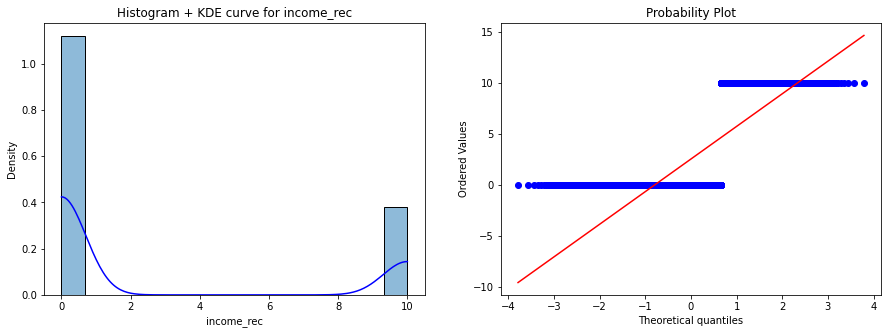

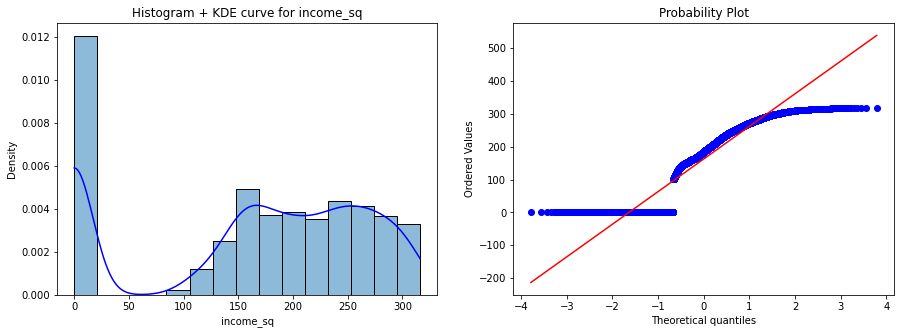

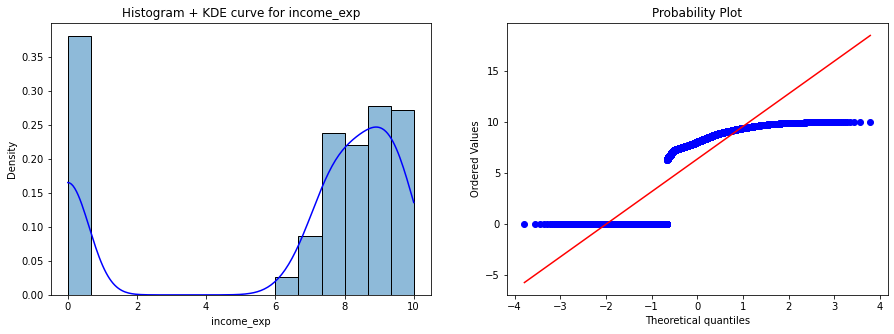

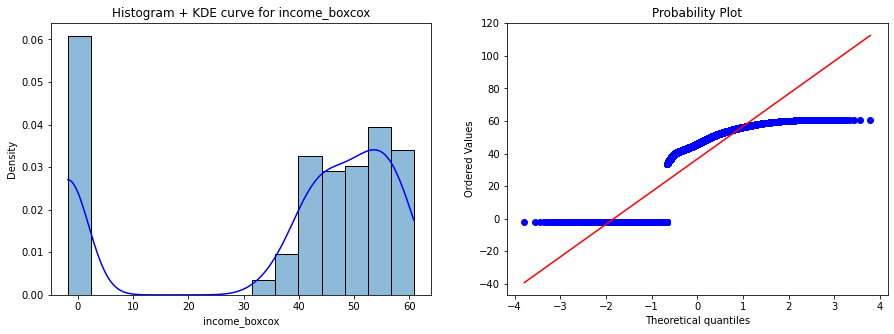

In [92]:
apply_all_transformations(df, 'income')

## Monthly premium auto

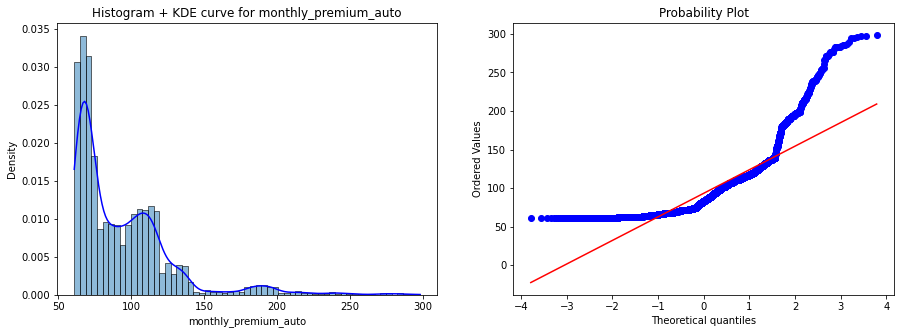

In [99]:
plot_distribution(df, 'monthly_premium_auto')

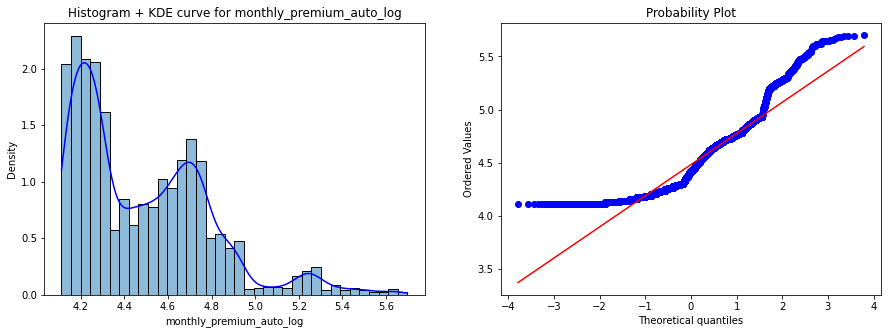

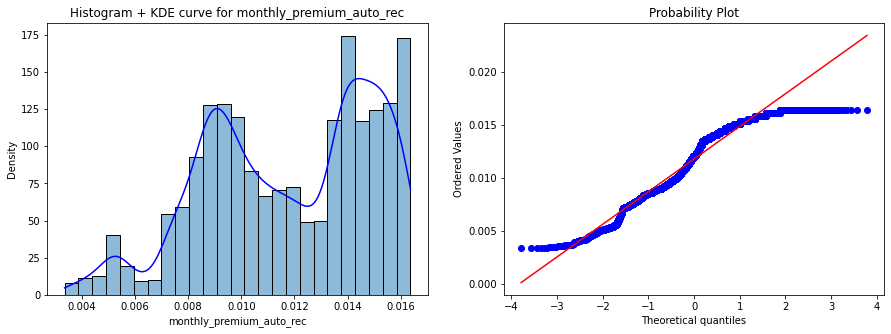

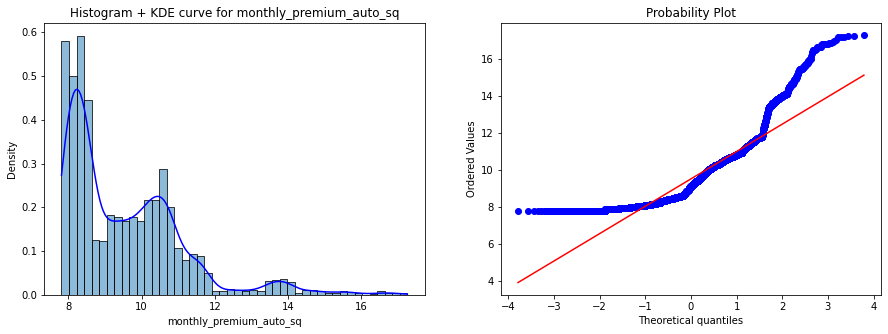

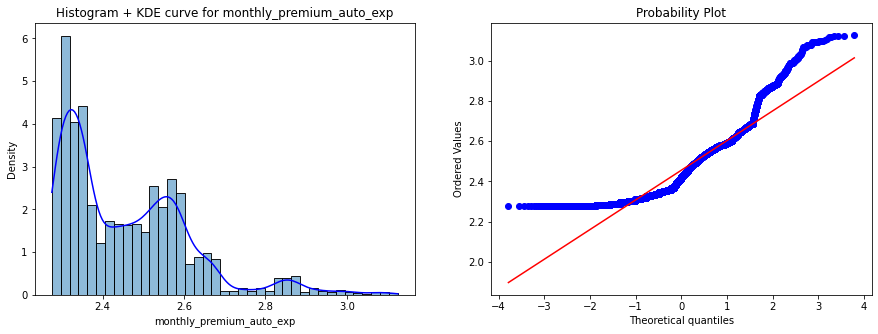

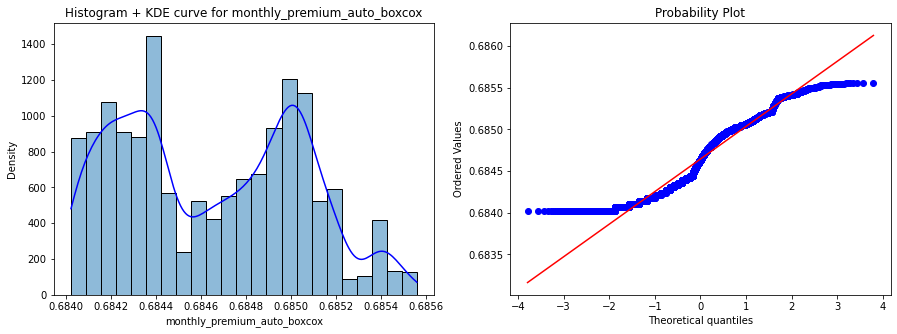

In [100]:
apply_all_transformations(df, 'monthly_premium_auto')

## months_since_last_claim

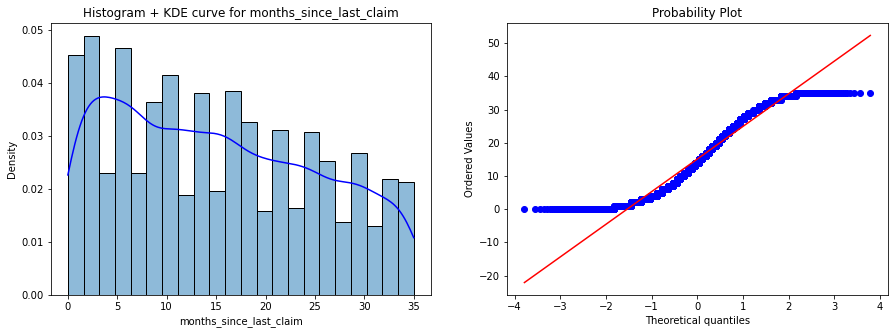

In [101]:
plot_distribution(df, 'months_since_last_claim')

In [102]:
numericals.columns

Index(['customer_lifetime_value', 'income', 'monthly_premium_auto',
       'months_since_last_claim', 'months_since_policy_inception',
       'number_of_open_complaints', 'number_of_policies',
       'total_claim_amount'],
      dtype='object')

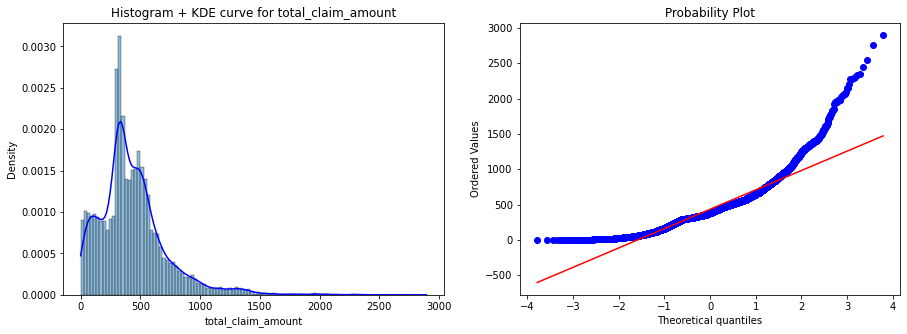

In [103]:
plot_distribution(df, 'total_claim_amount')

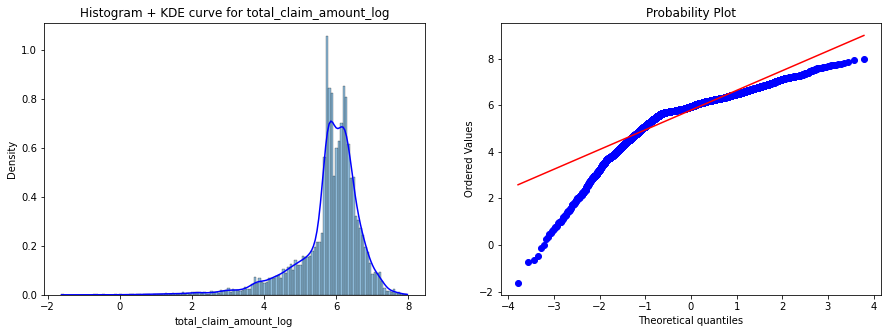

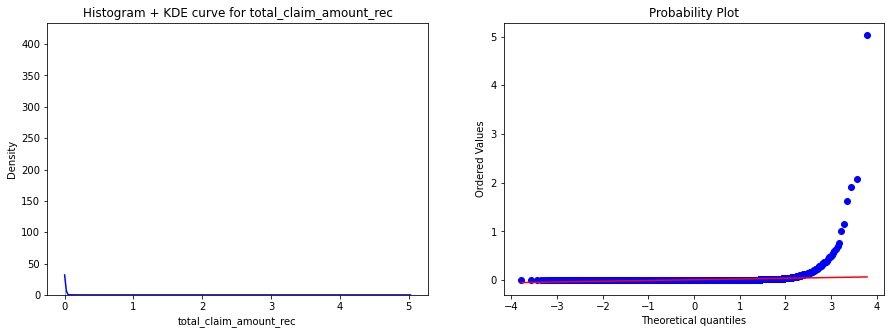

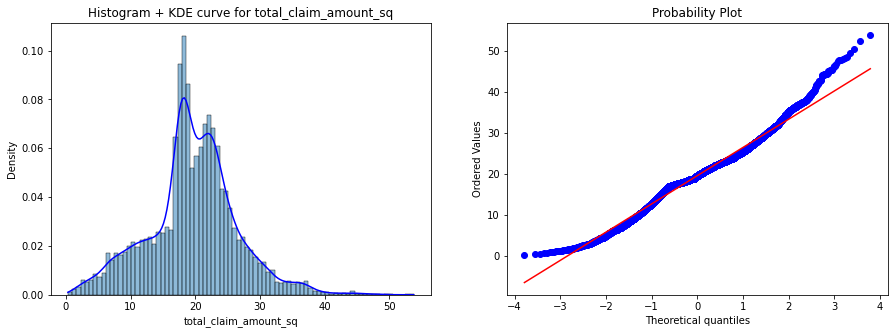

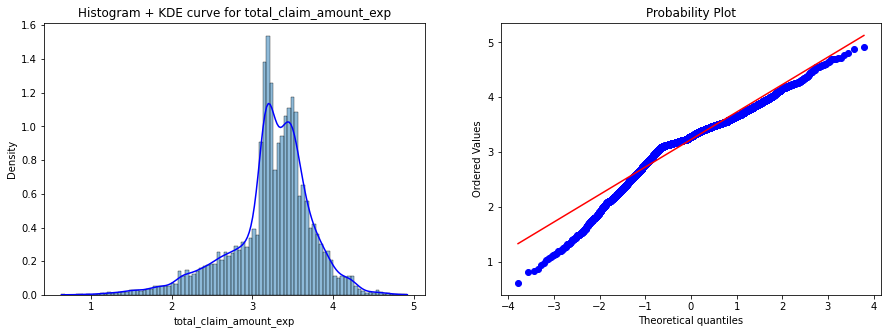

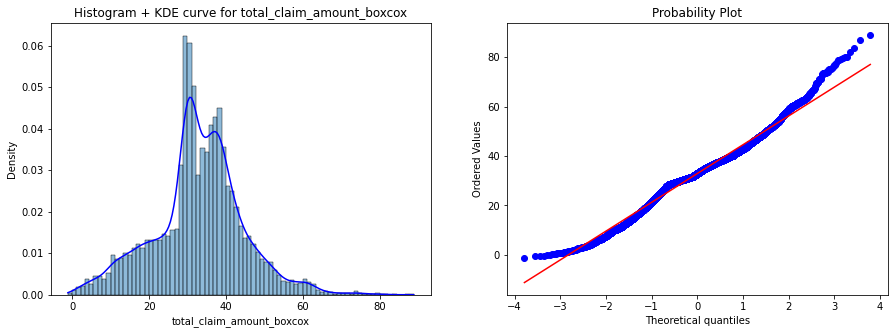

In [104]:
apply_all_transformations(df, 'total_claim_amount')